In [2]:
import pandas as pd
import pickle

# REMOVED
#import torch
#import transformers
#from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import sys
import csv
import re
from tqdm.notebook import tqdm
import sys
import csv
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from src.preprocess import *
from src.models import *
from src.lib import *
import matplotlib.pyplot as plt
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guilherme/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import datetime

log_dt_type = []
log_dt_model = []
log_dt_time = []


def time_to_run(start, end):
    times = end - start
    seconds = times.seconds
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%02d:%02d" % (hour, minutes, seconds)

def time_logger(type,model,start,end):
    log_dt_type.append(type)
    log_dt_model.append(model)
    log_dt_time.append(time_to_run(start,end))
    

## Explore data

### kinds of cause:
- 1 = No reason
- 2 = Bias or abuse
- 3 = Jobs and careers
- 4 = Medication
- 5 = Relationships
- 6 = Alienation

In [4]:

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

## Import training and Testing files
read_file_training = pd.read_csv('./data/added_CAMS_data.csv', encoding="ISO-8859-1")
read_file_testing = pd.read_csv('./data/IntentSDCNL_Testing.csv', encoding = "ISO-8859-1")

#training data
df_train = pd.DataFrame(read_file_training,columns= ['selftext','cause', 'inference']) # load data df_train
df_train = df_train.rename(columns={'selftext': 'text'}) # Rename columns:
df_train = df_train.convert_dtypes() # Convert columns to the best possible


#testing data
df_test = pd.DataFrame(read_file_testing,columns= ['selftext','ANNOTATIONS', 'Interpretations']) # load data df_test
df_test = df_test.rename(columns={'selftext': 'text', 'ANNOTATIONS': 'cause', 'Interpretations': 'inference'}) # Rename columns
df_test = df_test.convert_dtypes() # Convert columns to the best possible


In [5]:
# Removing some rows acoording rules below:
df_test.drop(df_test[df_test.text=="emptypost"].index, inplace=True)
df_test.drop(df_test[df_test.cause==" "].index, inplace=True)
df_test.drop(df_test[df_test.inference==" "].index, inplace=True)


# Removing some rows acoording rules below:
df_train.drop(df_train[df_train.text=="emptypost"].index, inplace=True)
df_train.drop(df_train[df_train.cause==" "].index, inplace=True)
df_train.drop(df_train[df_train.inference==" "].index, inplace=True)

# Removing all nulls from all datasets.
df_test.dropna(inplace=True)
df_train.dropna(inplace=True)


###### Class distribution of training data #####


<Axes: ylabel='count'>

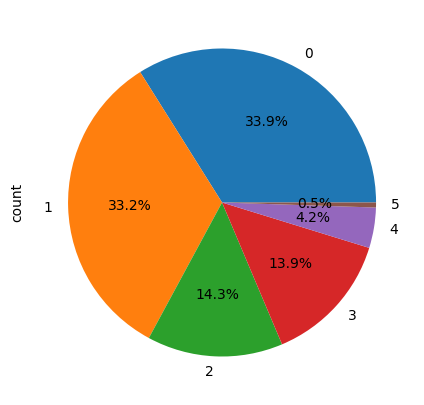

In [6]:

print("###### Class distribution of training data #####")
labels = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_train['cause'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)

###### Class distribution of testing data #####


<Axes: ylabel='count'>

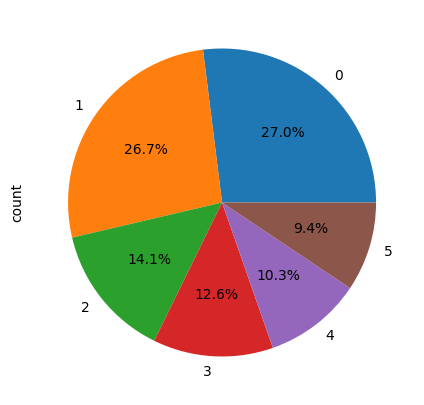

In [7]:

print("###### Class distribution of testing data #####")
labels = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_test['cause'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)

In [8]:
frame = [df_test, df_train]
data =  pd.concat(frame)
data

,text,cause,inference
0,"Indubitably, I am not worth anything as a being, contrary to the belief of all redditors who will reply to this, I have never once done anything correct in my life, all I have ever succeeded in has been to be hurtful and disrespectful to others and taking others for granted. All I breed is catastrophe. I am not at all talented or skilled at anything in particular, I am below average in every concept known to man. I have no motivation nor intention to progress in my life. I seem to be an inconvenience, an unpleasant burden towards society. I'd say my existence is more so comparable to a tumor, I am not productive and only produce negative effects on others that unfortunately have the unbearable pain that comes from interaction with someone like me. Entrapped in this body, I dream of going into eternal sleep, a great rest that lasts to the end of time. I do not have any interest in anything anymore, daily politics bore me a great deal and I'm not at all intrigued by life at all. I don't see a reason to not follow through with it when I have no intrinsic value and no drive nor intent to live at all.",1,"not productive, worthless, hate, bored , issues, excited, no motivation, challenge, inconvinience, catastrophe, graduate , ambition"
1,"Almost everyday I wake up hating myself, why would I hate myself though? I graduated High School, have a loving and healthy family, have hobbies and online friends. Yet I find myself so paranoid and hateful of myself, why do I deserve this life I have? Sometimes I just wanna scream, feeling like I'm trapped in another person's skin, I feel like all my accomplishments are fake and I'm a useless slab of meat who'll eventually die. I don't have real life friends, post secondary, a job, a car or a license and the closest family I have is 6 hours away and barely talks to me. I want to be happy for the good things in my life but find hating myself all too easy. When I hate myself I feel selfish, like I'm so self-absorbed that I only care about myself. I just want to be happy like people online or in my family, to just always see the glass half full and not always half empty",5,"feeling trapped, paranoid, barely talks to me, donât have real friends, wanna scream, online friends, fake accomplishments, miserable"
2,To kill myself if im ugly?,1,ugly
3,"God help me.... I know I should go to the hospital. I know I have to keep fighting....if only to prove to my children, cursed with these genetic tendencies of mine, that life is worth living. I made my son promise at Christmas to get help, and he did and he is thriving. My life long battle is starting to wear on this old soul of mine. It feels like the same pattern over and over, no matter how many variables I change. I am a very hard person to love. My scars and cynicism are just a little too hard for anyone who tries to stay around too long. Hubby has been in my atmosphere for 7 years...think it's finally getting through to him that I can not change the abuse I suffered, and the PTSD that resides in me and rears it's ugly head now and then. My mother never wanted me and beat her belly before I was ever born....almost 50 years later and I still feel as unlovable. I'm so tired. My kids will be so pissed if I give up....my bf needs me right now....I can't abandon them all....Heaven help me.....I just want it to stop hurting all the time.",1,"abuse suffered, hard person to love, scars, cyncism, feel unlovable, genetic tendencies"
4,"I really don't want to do anything anymore. Whatever I do, I'll just feel like a failure. I always feel like a failure and a disappointment to anybody who is unlucky enough to know me. All I do is lay in bed now, go to school, then lay in bed at home. I keep wasting money on stupid shit to try and do something (miniature wargaming, d&amp;d, etc.) but I always just give up and go back to sulking. I fucking hate my life. This is the only place I can vent.",2,"wasting money, sulking, failure, disappointment, 

#### A Sample

In [9]:
# print_plot(df_train,0)

## Clean and preprocess the text

####  Clean Training and Testing data

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    # text = contractions.fix(text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)     
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


#training data
df_train = df_train.reset_index(drop=True)
df_train['orig_text'] = df_train['text']
df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'] = df_train['text'].str.replace('\d+', '')

##testing data
df_test = df_test.reset_index(drop=True)
df_test['orig_text'] = df_test['text']
df_test['text'] = df_test['text'].apply(clean_text)
df_test['text'] = df_test['text'].str.replace('\d+', '')



#### A sample after cleanup

In [11]:
print_plot(df_train,0)
len(df_train)

look like drug addict lost much weight cant hold much food without throwing literally look anoreic eye bags bad theyre dark deep stop effects mom sees dont want know im depressed told look horrible dont like tell people depression either knowing people theyll make feel like depression isnt bad look like drug addict everyone need stop
text: 3


2877

#### Intialize parameters

In [12]:
# Define some Global Variables
max_nb_words = 60000
max_features = 10543 # Maximum Number of words we want to include in our dictionary
maxlen = 500 # No of words in question we want to create a sequence with
emb_dim = 100 # Size of word to vec embedding we are usingtokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

#### Initial Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values) # tokenizer on whole training and testing data
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 18102 unique tokens.


In [14]:
X_train = tokenizer.texts_to_sequences(df_train['text'].values)
X_train = pad_sequences(X_train, maxlen=maxlen)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (2877, 500)


In [15]:
Y_train = pd.get_dummies(df_train['cause']).values
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (2877, 6)


In [16]:
X_test = tokenizer.texts_to_sequences(df_test['text'].values)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (341, 500)


In [17]:
Y_test = pd.get_dummies(df_test['cause']).values
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (341, 6)


### Finally some validation data from Training Data

In [18]:
# Split arrays or matrices into random train and test subsets.
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,random_state=0,test_size=0.1)

In [19]:
print('TrainingData',X_train.shape,Y_train.shape)
print('TestingData',X_test.shape,Y_test.shape)
print('ValidationData',X_val.shape,Y_val.shape)


TrainingData (2589, 500) (2589, 6)
TestingData (341, 500) (341, 6)
ValidationData (288, 500) (288, 6)


In [20]:
#print a test sample
#print('test example:', X_test[100])
#len(X_test[100])

#### Intialize Embedding

In [21]:
embedding_vectors = {}

with open(f'./embeddings/glove.6B.{emb_dim}d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
        
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")


Size of vocabulary in GloVe: 400000


In [22]:
#initialize the embedding_matrix with zeros

if max_nb_words is not None: 
    vocab_len = max_nb_words
else:
    vocab_len = len(word_index)+1
    
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []

for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
            
#Check some of the out of vocabulary words
print(f'A few out of valubulary words: {len(oov_words)}')
print(f'A few out of valubulary words: {oov_words[0:10]}')

# saving the oov words to a csv file.
list_to_csv = {'out_of_vocabulary':oov_words}
list_to_csv = pd.DataFrame(list_to_csv)
list_to_csv.to_csv('./tmp/oov.csv',encoding='utf-8')

A few out of valubulary words: 4066
A few out of valubulary words: ["i'm", "don't", "i've", "it's", '\n\ni', "can't", 'iâ\x80\x99m', "didn't", 'donâ\x80\x99t', "doesn't"]


In [23]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

4066 out of 60000 words were OOV.


## NN models

In [24]:
##Global variables
batch_size = 256
epochs  = 20
models_list = []

#### a) LSTM Model

In [25]:
lstm_model = LSTM_model(embedding_matrix,vocab_len,emb_dim)
models_list.append({'name':'lstm','model':lstm_model})

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         6000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 6,118,022
Trainable params: 118,022


2023-08-26 20:10:25.484302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:10:25.491274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:10:25.493565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Non-trainable params: 6,000,000
_________________________________________________________________
None


##### Train the model

In [26]:
%%time
history = lstm_model.fit(X_train, np.asarray(Y_train)
                        , validation_data = (X_val, np.asarray(Y_val))
                        , batch_size = batch_size
                        , epochs = epochs
                        , verbose = 2
                    )

Epoch 1/20


2023-08-26 20:10:26.695134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:10:26.698869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:10:26.707137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 - 28s - loss: 1.6050 - accuracy: 0.2920 - val_loss: 1.4344 - val_accuracy: 0.3750 - 28s/epoch - 3s/step
Epoch 2/20
11/11 - 18s - loss: 1.4863 - accuracy: 0.3453 - val_loss: 1.4252 - val_accuracy: 0.4028 - 18s/epoch - 2s/step
Epoch 3/20
11/11 - 17s - loss: 1.4631 - accuracy: 0.3642 - val_loss: 1.4174 - val_accuracy: 0.3854 - 17s/epoch - 2s/step
Epoch 4/20
11/11 - 17s - loss: 1.4473 - accuracy: 0.3785 - val_loss: 1.4157 - val_accuracy: 0.3507 - 17s/epoch - 2s/step
Epoch 5/20
11/11 - 17s - loss: 1.4230 - accuracy: 0.3785 - val_loss: 1.4058 - val_accuracy: 0.3889 - 17s/epoch - 2s/step
Epoch 6/20
11/11 - 17s - loss: 1.3988 - accuracy: 0.4075 - val_loss: 1.3803 - val_accuracy: 0.3958 - 17s/epoch - 2s/step
Epoch 7/20
11/11 - 17s - loss: 1.3900 - accuracy: 0.4059 - val_loss: 1.4878 - val_accuracy: 0.4201 - 17s/epoch - 2s/step
Epoch 8/20
11/11 - 17s - loss: 1.4572 - accuracy: 0.3967 - val_loss: 1.4127 - val_accuracy: 0.4271 - 17s/epoch - 2s/step
Epoch 9/20
11/11 - 17s - loss: 1.4066 - acc

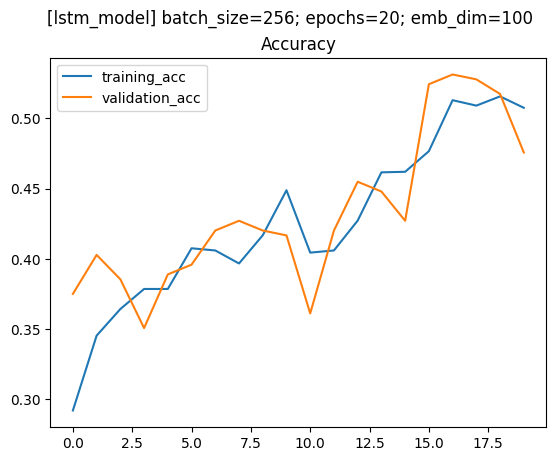

In [27]:
#plot accuracy
plot_accuracy(history,epochs,f"[lstm_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [28]:
# Accuracy
train_test_accuracy(lstm_model,X_train,Y_train,X_test,Y_test)


Train accuracy: 51.72
Test accuracy: 42.23


In [29]:
#Classification report
report_nn(lstm_model,X_test,Y_test)

2023-08-26 20:16:32.021680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:16:32.023671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:16:32.025586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 2s 136ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        35
           2       0.46      0.67      0.54        48
           3       0.82      0.21      0.33        43
           4       0.37      0.76      0.49        91
           5       0.48      0.37      0.42        92

    accuracy                           0.42       341
   macro avg       0.35      0.33      0.30       341
weighted avg       0.39      0.42      0.36       341

accuracy: 0.422


/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### b) CNN

In [30]:
cnn_model=CNN_model(embedding_matrix,vocab_len)
models_list.append({'name':'cnn','model':cnn_model})

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         6000000   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         49280     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 6)                

##### Train the model

In [31]:
%%time
history = cnn_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),batch_size = batch_size, epochs = epochs)

Epoch 1/20
11/11 [==============================] - 4s 272ms/step - loss: 1.6276 - accuracy: 0.3148 - val_loss: 1.4579 - val_accuracy: 0.3576
Epoch 2/20
11/11 [==============================] - 3s 265ms/step - loss: 1.3924 - accuracy: 0.4295 - val_loss: 1.4190 - val_accuracy: 0.3958
Epoch 3/20
11/11 [==============================] - 3s 260ms/step - loss: 1.3107 - accuracy: 0.4820 - val_loss: 1.3496 - val_accuracy: 0.4201
Epoch 4/20
11/11 [==============================] - 3s 249ms/step - loss: 1.2207 - accuracy: 0.5350 - val_loss: 1.2862 - val_accuracy: 0.4583
Epoch 5/20
11/11 [==============================] - 3s 245ms/step - loss: 1.1524 - accuracy: 0.5902 - val_loss: 1.2708 - val_accuracy: 0.4792
Epoch 6/20
11/11 [==============================] - 3s 247ms/step - loss: 1.0922 - accuracy: 0.6165 - val_loss: 1.2416 - val_accuracy: 0.4757
Epoch 7/20
11/11 [==============================] - 3s 241ms/step - loss: 1.0334 - accuracy: 0.6477 - val_loss: 1.2333 - val_accuracy: 0.4965
Epoch 

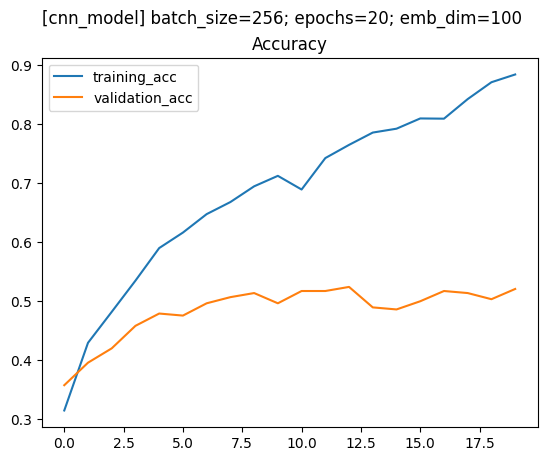

In [32]:
#plot accuracy
plot_accuracy(history,epochs,f"[cnn_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [33]:
# Accuracy
train_test_accuracy(cnn_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 90.50
Test accuracy: 47.21


In [34]:
#Classification report
report_nn(cnn_model,X_test,Y_test)

11/11 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        35
           2       0.57      0.35      0.44        48
           3       0.46      0.53      0.49        43
           4       0.53      0.59      0.56        91
           5       0.42      0.73      0.53        92

    accuracy                           0.47       341
   macro avg       0.33      0.37      0.34       341
weighted avg       0.39      0.47      0.42       341

accuracy: 0.472


/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### d) GRU

In [35]:
gru_model = GRU_model(embedding_matrix,vocab_len)
models_list.append({'name':'gru','model':gru_model})

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         6000000   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 6,089,094
Trainable params: 89,094
Non-trainable params: 6,000,000
_________________________________________________________________


2023-08-26 20:17:32.966630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:17:32.969758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:17:32.971724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [36]:
%%time
history = gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs)

Epoch 1/20


2023-08-26 20:17:33.430524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:17:33.433662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:17:33.435777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 1.5963 - accuracy: 0.3187

2023-08-26 20:17:50.237741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:17:50.240546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:17:50.242227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 18s 1s/step - loss: 1.5963 - accuracy: 0.3187 - val_loss: 1.4392 - val_accuracy: 0.3646
Epoch 2/20
11/11 [==============================] - 15s 1s/step - loss: 1.5158 - accuracy: 0.3322 - val_loss: 1.4313 - val_accuracy: 0.3576
Epoch 3/20
11/11 [==============================] - 16s 1s/step - loss: 1.4726 - accuracy: 0.3492 - val_loss: 1.4209 - val_accuracy: 0.3576
Epoch 4/20
11/11 [==============================] - 16s 1s/step - loss: 1.4518 - accuracy: 0.3743 - val_loss: 1.4272 - val_accuracy: 0.3542
Epoch 5/20
11/11 [==============================] - 17s 2s/step - loss: 1.4374 - accuracy: 0.3666 - val_loss: 1.4222 - val_accuracy: 0.3576
Epoch 6/20
11/11 [==============================] - 16s 1s/step - loss: 1.4269 - accuracy: 0.3832 - val_loss: 1.4218 - val_accuracy: 0.3715
Epoch 7/20
11/11 [==============================] - 17s 2s/step - loss: 1.4239 - accuracy: 0.3878 - val_loss: 1.4222 - val_accuracy: 0.3715
Epoch 8/20
11/11 [=============

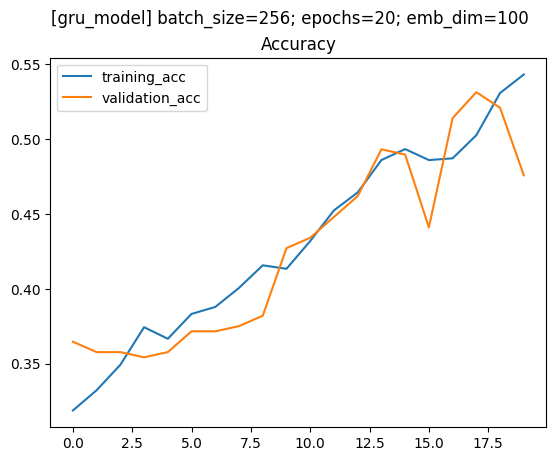

In [37]:
#plot accuracy
plot_accuracy(history,epochs,f"[gru_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [38]:
# Accuracy
train_test_accuracy(gru_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 53.38
Test accuracy: 41.64


In [39]:
#Classification report
report_nn(gru_model,X_test,Y_test)


2023-08-26 20:22:59.101850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:22:59.103783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:22:59.105356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 2s 119ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        35
           2       0.52      0.23      0.32        48
           3       0.60      0.21      0.31        43
           4       0.40      0.88      0.55        91
           5       0.40      0.46      0.43        92

    accuracy                           0.42       341
   macro avg       0.32      0.30      0.27       341
weighted avg       0.36      0.42      0.35       341

accuracy: 0.416


/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### e) CNN+GRU

In [40]:
cnn_gru_model = CNN_GRU_model(embedding_matrix,vocab_len)
models_list.append({'name':'cnn_gru','model':cnn_gru_model})

2023-08-26 20:23:00.922757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:23:00.925504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:23:00.927002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         6000000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          19264     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 gru_1 (GRU)                 (None, None, 128)         74496     
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

/home/guilherme/.local/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [41]:
%%time
history=cnn_gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

Epoch 1/20


2023-08-26 20:23:01.556347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:23:01.559114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:23:01.560659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 1.5299 - accuracy: 0.3125

2023-08-26 20:23:22.082937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:23:22.085471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:23:22.287970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 22s 2s/step - loss: 1.5299 - accuracy: 0.3125 - val_loss: 1.4258 - val_accuracy: 0.3576
Epoch 2/20
11/11 [==============================] - 18s 2s/step - loss: 1.4439 - accuracy: 0.3550 - val_loss: 1.4236 - val_accuracy: 0.3715
Epoch 3/20
11/11 [==============================] - 18s 2s/step - loss: 1.4242 - accuracy: 0.3835 - val_loss: 1.4054 - val_accuracy: 0.3750
Epoch 4/20
11/11 [==============================] - 18s 2s/step - loss: 1.4070 - accuracy: 0.3843 - val_loss: 1.3859 - val_accuracy: 0.3958
Epoch 5/20
11/11 [==============================] - 18s 2s/step - loss: 1.3774 - accuracy: 0.4017 - val_loss: 1.3572 - val_accuracy: 0.3958
Epoch 6/20
11/11 [==============================] - 19s 2s/step - loss: 1.3289 - accuracy: 0.4430 - val_loss: 1.4967 - val_accuracy: 0.3229
Epoch 7/20
11/11 [==============================] - 18s 2s/step - loss: 1.3244 - accuracy: 0.4658 - val_loss: 1.3268 - val_accuracy: 0.4653
Epoch 8/20
11/11 [=============

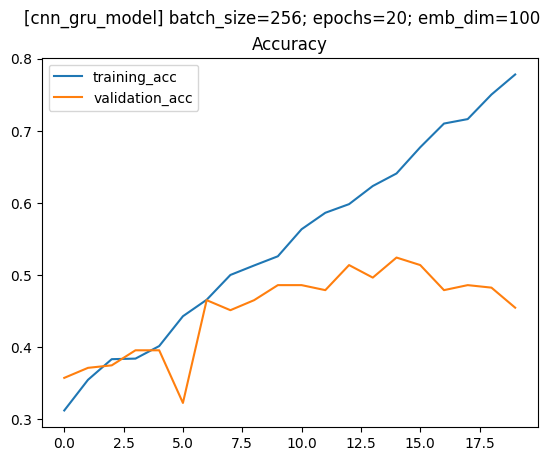

In [42]:
#plot accuracy
plot_accuracy(history,epochs,f"[cnn_gru_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [43]:
# Accuracy
train_test_accuracy(cnn_gru_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 80.73
Test accuracy: 41.64


In [44]:
#Classification report
report_nn(cnn_gru_model,X_test,Y_test)

2023-08-26 20:29:39.391938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:29:39.396014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:29:39.398096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 2s 135ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.25      0.09      0.13        35
           2       0.40      0.42      0.41        48
           3       0.48      0.53      0.51        43
           4       0.43      0.51      0.46        91
           5       0.41      0.54      0.47        92

    accuracy                           0.42       341
   macro avg       0.33      0.35      0.33       341
weighted avg       0.37      0.42      0.38       341

accuracy: 0.416


#### f) CNN+LSTM

In [45]:
cnn_lstm_model = CNN_LSTM_model(embedding_matrix,vocab_len)
models_list.append({'name':'cnn_lstm','model':cnn_lstm_model})

2023-08-26 20:29:41.906476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:29:41.908878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:29:41.912883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         6000000   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          19264     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         98816     
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                      

2023-08-26 20:29:42.209906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:29:42.214333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:29:42.216329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [46]:
%%time
history=cnn_lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

Epoch 1/20


2023-08-26 20:29:42.802020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:29:42.805123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:29:42.807134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 1.5294 - accuracy: 0.3360

2023-08-26 20:30:09.969281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:30:09.974875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:30:09.980197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 30s 2s/step - loss: 1.5294 - accuracy: 0.3360 - val_loss: 1.4232 - val_accuracy: 0.3750
Epoch 2/20
11/11 [==============================] - 23s 2s/step - loss: 1.4545 - accuracy: 0.3418 - val_loss: 1.4223 - val_accuracy: 0.3646
Epoch 3/20
11/11 [==============================] - 22s 2s/step - loss: 1.4269 - accuracy: 0.3581 - val_loss: 1.3788 - val_accuracy: 0.4167
Epoch 4/20
11/11 [==============================] - 21s 2s/step - loss: 1.3781 - accuracy: 0.4036 - val_loss: 1.3902 - val_accuracy: 0.3819
Epoch 5/20
11/11 [==============================] - 21s 2s/step - loss: 1.3652 - accuracy: 0.4206 - val_loss: 1.3472 - val_accuracy: 0.4062
Epoch 6/20
11/11 [==============================] - 21s 2s/step - loss: 1.3183 - accuracy: 0.4562 - val_loss: 1.3561 - val_accuracy: 0.4375
Epoch 7/20
11/11 [==============================] - 21s 2s/step - loss: 1.2981 - accuracy: 0.4759 - val_loss: 1.3063 - val_accuracy: 0.4826
Epoch 8/20
11/11 [=============

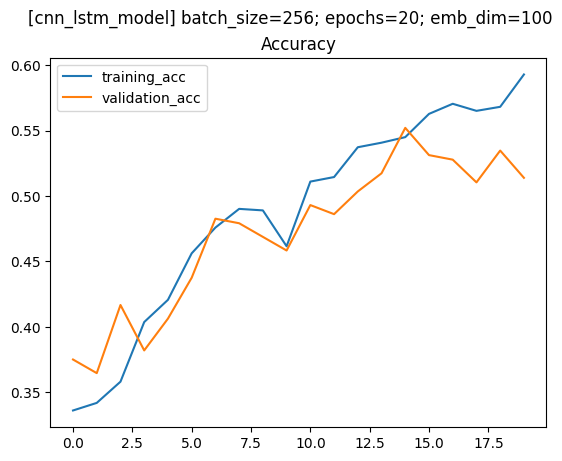

In [47]:
#plot accuracy
plot_accuracy(history, epochs,f"[cnn_lstm_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [48]:
# Accuracy
train_test_accuracy(cnn_lstm_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 54.58
Test accuracy: 45.45


In [49]:
#Classification report
report_nn(cnn_lstm_model,X_test,Y_test)

2023-08-26 20:36:54.672471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:36:54.676437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:36:54.678164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 3s 173ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        35
           2       0.45      0.77      0.56        48
           3       0.45      0.49      0.47        43
           4       0.63      0.36      0.46        91
           5       0.40      0.70      0.51        92

    accuracy                           0.45       341
   macro avg       0.32      0.39      0.33       341
weighted avg       0.40      0.45      0.40       341

accuracy: 0.455


/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Confusion Matrix

--Confusion Matrix for CNN+LSTM--
11/11 [==============================] - 2s 149ms/step


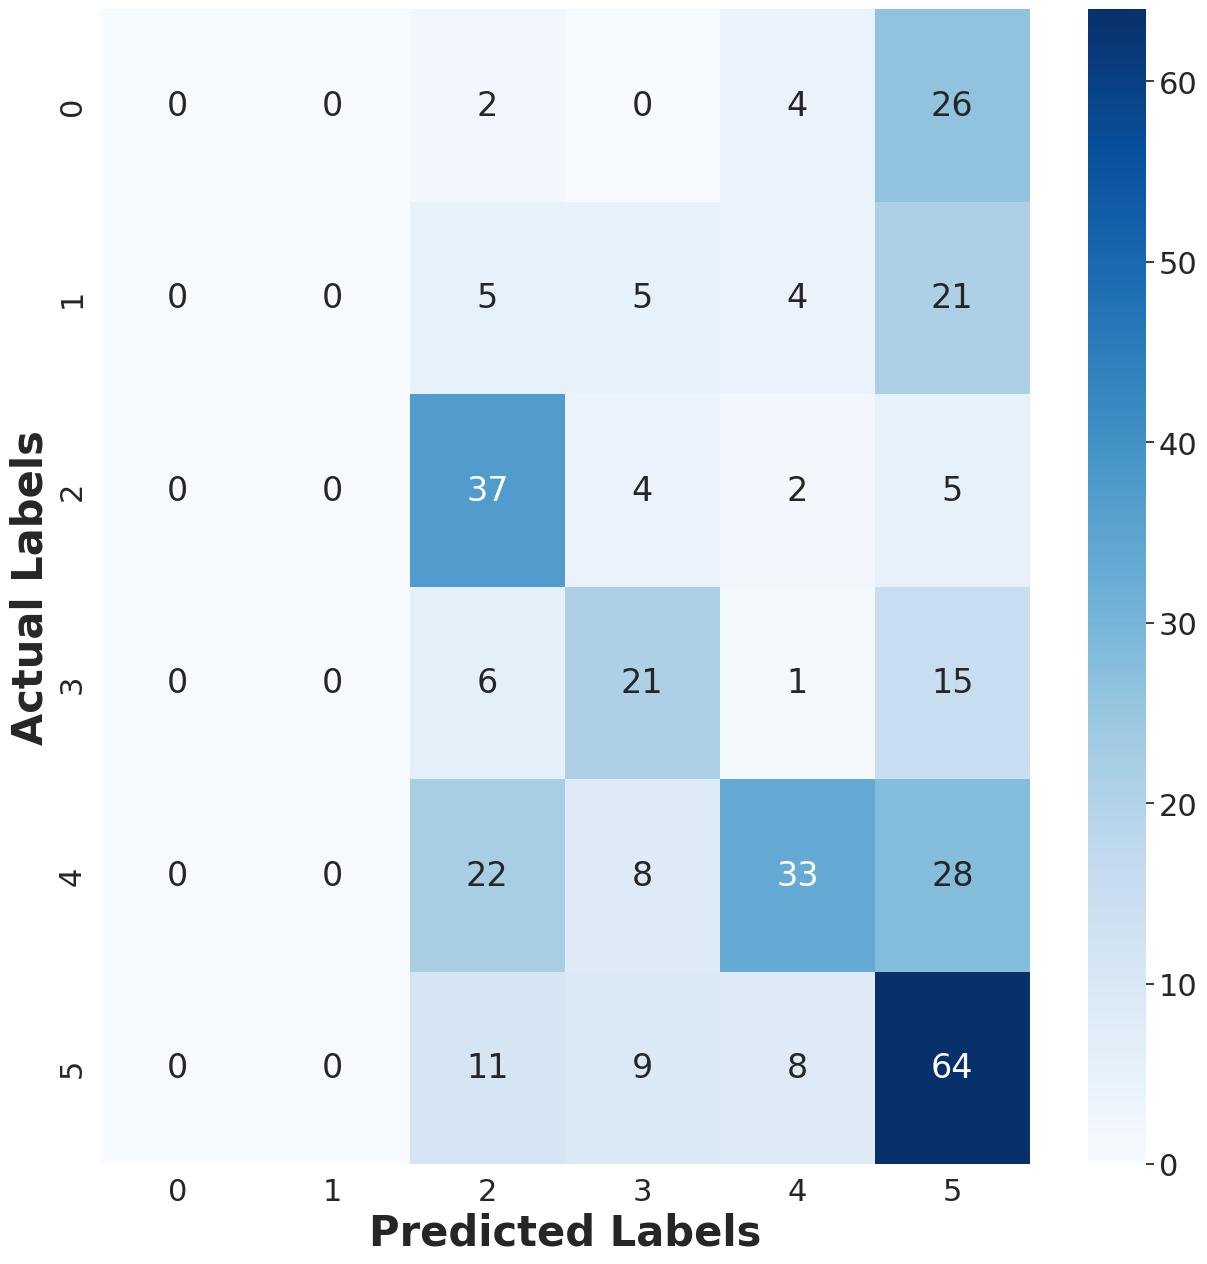

In [50]:
#cnn_lstm_model0=cnn_lstm_model
print('--Confusion Matrix for CNN+LSTM--')
print_confusion(cnn_lstm_model,X_test,Y_test)

#### Bidirectional LSTM models

In [51]:
lstmbd_model = BID_LSTM_model(embedding_matrix,vocab_len,emb_dim)
models_list.append({'name':'lstmbd','model':lstmbd_model})

2023-08-26 20:37:19.836078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:37:19.840937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:37:19.843048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 6,236,038
Trainable params: 236,038
Non-trainable params: 6,000,000
_________________________________________________________________


2023-08-26 20:37:20.237236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-08-26 20:37:20.314211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:37:20.316467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [52]:
%%time
history=lstmbd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

Epoch 1/20


2023-08-26 20:37:20.920363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:37:20.925529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:37:20.928450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 1.6115 - accuracy: 0.3001

2023-08-26 20:37:54.232984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:37:54.234591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:37:54.237718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 35s 3s/step - loss: 1.6115 - accuracy: 0.3001 - val_loss: 1.4392 - val_accuracy: 0.3229
Epoch 2/20
11/11 [==============================] - 25s 2s/step - loss: 1.4663 - accuracy: 0.3414 - val_loss: 1.4261 - val_accuracy: 0.3472
Epoch 3/20
11/11 [==============================] - 26s 2s/step - loss: 1.4479 - accuracy: 0.3762 - val_loss: 1.4156 - val_accuracy: 0.3576
Epoch 4/20
11/11 [==============================] - 24s 2s/step - loss: 1.4285 - accuracy: 0.3638 - val_loss: 1.4171 - val_accuracy: 0.3715
Epoch 5/20
11/11 [==============================] - 25s 2s/step - loss: 1.4150 - accuracy: 0.3874 - val_loss: 1.3919 - val_accuracy: 0.3785
Epoch 6/20
11/11 [==============================] - 25s 2s/step - loss: 1.3874 - accuracy: 0.4032 - val_loss: 1.4164 - val_accuracy: 0.4097
Epoch 7/20
11/11 [==============================] - 25s 2s/step - loss: 1.3614 - accuracy: 0.4311 - val_loss: 1.4188 - val_accuracy: 0.4028
Epoch 8/20
11/11 [=============

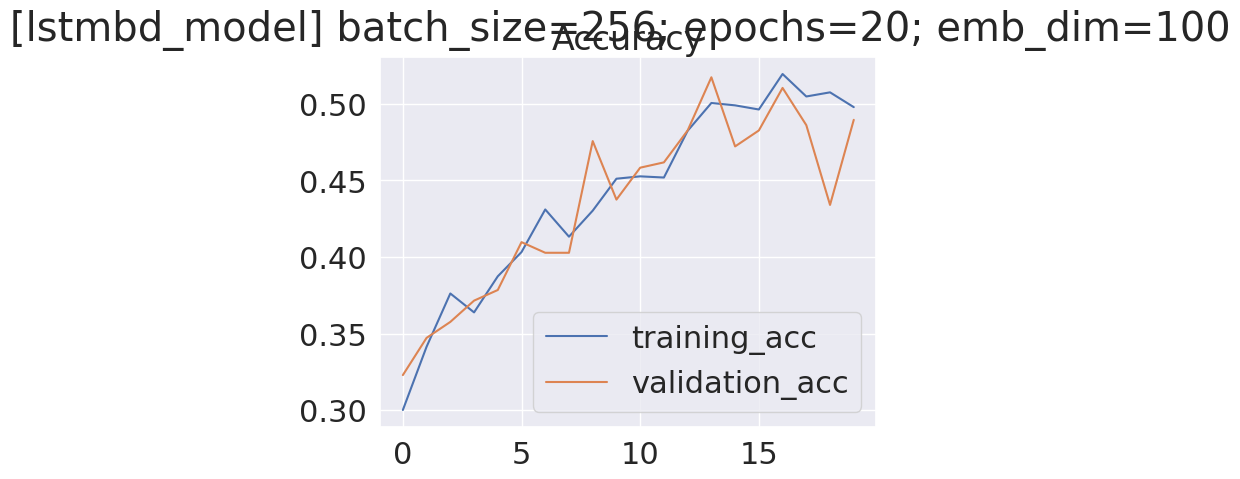

In [53]:
#plot accuracy
plot_accuracy(history,epochs,f"[lstmbd_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [54]:
# Accuracy
train_test_accuracy(lstmbd_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 51.06
Test accuracy: 43.40


In [55]:
#Classification report
report_nn(lstmbd_model,X_test,Y_test)

2023-08-26 20:45:58.222413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:45:58.223877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:45:58.225973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 2s 166ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        35
           2       0.20      0.02      0.04        48
           3       0.56      0.35      0.43        43
           4       0.41      0.89      0.56        91
           5       0.46      0.55      0.50        92

    accuracy                           0.43       341
   macro avg       0.27      0.30      0.25       341
weighted avg       0.33      0.43      0.34       341

accuracy: 0.434


/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Bidirectional GRU

In [56]:
grubd_model = BID_GRU_model(embedding_matrix,vocab_len,emb_dim)
models_list.append({'name':'grubd','model':grubd_model})

2023-08-26 20:46:00.887662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:46:00.890080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:46:00.891897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         6000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              176640    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 6,178,182
Trainable params: 178,182
Non-trainable params: 6,000,000
_________________________________________________________________


In [57]:
%%time
history=grubd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

Epoch 1/20


2023-08-26 20:46:01.510319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:46:01.512542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:46:01.515909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 1.5955 - accuracy: 0.3221

2023-08-26 20:46:26.508715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:46:26.511104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:46:26.514231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 27s 2s/step - loss: 1.5955 - accuracy: 0.3221 - val_loss: 1.4415 - val_accuracy: 0.3785
Epoch 2/20
11/11 [==============================] - 24s 2s/step - loss: 1.4904 - accuracy: 0.3349 - val_loss: 1.4300 - val_accuracy: 0.3576
Epoch 3/20
11/11 [==============================] - 23s 2s/step - loss: 1.4564 - accuracy: 0.3596 - val_loss: 1.4221 - val_accuracy: 0.3611
Epoch 4/20
11/11 [==============================] - 22s 2s/step - loss: 1.4433 - accuracy: 0.3754 - val_loss: 1.4234 - val_accuracy: 0.3681
Epoch 5/20
11/11 [==============================] - 22s 2s/step - loss: 1.4323 - accuracy: 0.3696 - val_loss: 1.4191 - val_accuracy: 0.3715
Epoch 6/20
11/11 [==============================] - 22s 2s/step - loss: 1.4249 - accuracy: 0.3778 - val_loss: 1.4214 - val_accuracy: 0.3889
Epoch 7/20
11/11 [==============================] - 23s 2s/step - loss: 1.4038 - accuracy: 0.3901 - val_loss: 1.4215 - val_accuracy: 0.3611
Epoch 8/20
11/11 [=============

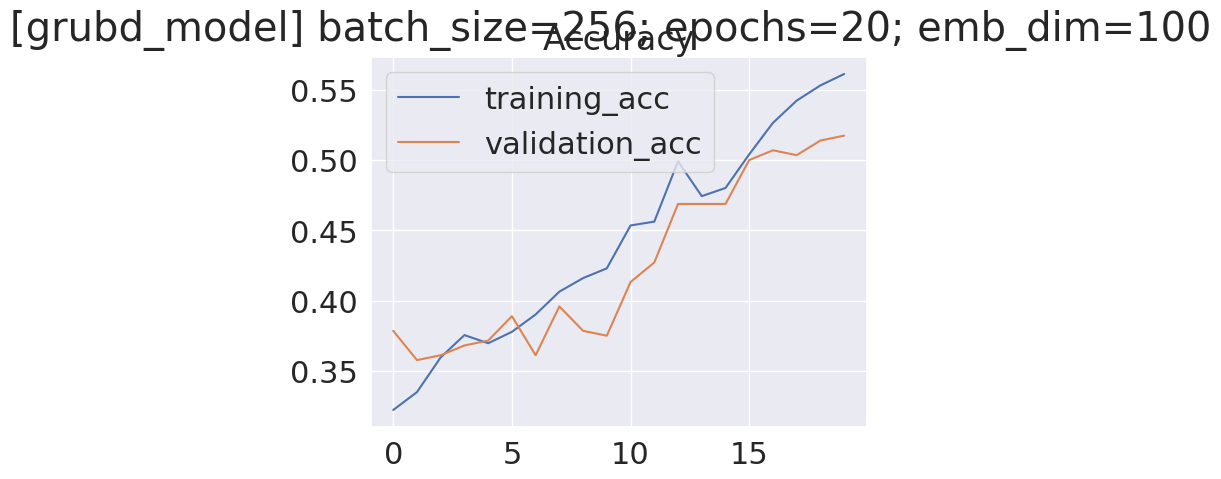

In [58]:
#plot accuracy
plot_accuracy(history,epochs,f"[grubd_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [59]:
# Accuracy
train_test_accuracy(grubd_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 57.78
Test accuracy: 45.45


In [60]:
#Classification report
report_nn(grubd_model,X_test,Y_test)

2023-08-26 20:53:48.402843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 20:53:48.404922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 20:53:48.408098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 3s 163ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        35
           2       0.45      0.52      0.48        48
           3       0.73      0.26      0.38        43
           4       0.50      0.52      0.51        91
           5       0.41      0.78      0.54        92

    accuracy                           0.45       341
   macro avg       0.35      0.35      0.32       341
weighted avg       0.40      0.45      0.40       341

accuracy: 0.455


/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### PREDICT all models

#### Preparing dataset

In [61]:
# Params

labels = ["No reason", "Bias or abuse", "Jobs and careers", "Medication", "Relationships", "Alienation"]
# file_to_predict = './tmp/tweets_to_predict_test.csv'
file_to_predict = './data/tweets_to_predict.csv'

In [103]:
USERNAME_RE = re.compile('@[^ ]+') # Remove twitter's username
HIPERLINK_RE = re.compile('https?:\/\/\S+') # Remove hiperlinks
QUOT_RE = re.compile('&quot;') # Remove special characters texted

def clean_predict_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = USERNAME_RE.sub('', text)
    text = HIPERLINK_RE.sub('', text)
    text = QUOT_RE.sub('', text)
    text = clean_text(text)
    return text

#predicting data
read_file_predict = pd.read_csv(file_to_predict, encoding = "ISO-8859-1")
df_predict = pd.DataFrame(read_file_predict,columns= ['target','text'])
df_predict = df_predict.convert_dtypes() # Convert columns to the best possible
df_predict = df_predict[df_predict.target == 0]
df_predict['original_text'] = df_predict['text']
df_predict.dropna(inplace=True)



df_predict = df_predict.reset_index(drop=True)
df_predict['text'] = df_predict['text'].apply(clean_predict_text)
df_predict['text'] = df_predict['text'].str.replace('\d+', '')
df_predict = df_predict.sample(n=25000)

len(df_predict)

25000

In [63]:
# model_predict function

def model_predict(model, text, labels, numOfWords):
    '''
    Return the following fields in a Pandas dataframe
    - cause: Cause predicted by model
    - percent: Percent of classification
    - text: text classified
    
       
    Attributes
    ----------
    model: sequencial
        Model used to predict text
        
    text: string
        text to classify
        
    labels: list
        Classifications that can be defined by [model]. It need to be from 0 to 6.
        
        kinds of cause:
            1 = No reason\n
            2 = Bias or abuse\n
            3 = Jobs and careers\n
            4 = Medication\n
            5 = Relationships\n
            6 = Alienation\n
        
    numOfWords: int
        Number of words.

    '''
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(seq, maxlen=numOfWords)
    predict = model.predict(padded)
    # labels = ["0-No reason", "1-Bias or abuse", "2-Jobs and careers", "3-Medication", "4-Relationships", "5-Alienation"]

    text_list = []
    cause_id_list = []
    cause_desc_list = []
    percent_list = []

    for index, tweet in enumerate(df_predict['text'].values):
        perc = np.argmax(predict[index])
        text_list.append(df_predict['original_text'][index])
        cause_desc_list.append(labels[np.argmax(predict[index])])
        cause_id_list.append(np.argmax(predict[index]))
        percent_list.append(predict[index][perc])
        #print(labels[perc], predict[index],predict[index][perc], df_predict['original_text'][index],f'({tweet})')
        
    df_text_predicted = pd.DataFrame({
                                      'cause_id': cause_id_list
                                    , 'cause_desc': cause_desc_list
                                    , 'percent': percent_list
                                    , 'text': text_list
                                    })
    
    return df_text_predicted

In [64]:
## Predicting X_test

# padded = pad_sequences(X_test, maxlen=maxlen)
# predict = lstm_model.predict(padded)


# for i, p in enumerate(df_test['text'].values):
#     model_class = np.argmax(predict[i])
#     model_perc = predict[model_class][model_class]
#     print(i, model_class,model_perc,p)
#     # print(labels[perc], predict[index],predict[index][perc], f'({tweet})')

#### Predictions

In [66]:
for model_dict in models_list:
    
    start = datetime.datetime.now()
    
    nmodel = model_dict['name']
    pmodel = model_dict['model']
    df_to_csv = model_predict(pmodel,df_predict['text'].values,labels,maxlen)
    df_to_csv.to_csv(f'./results/predictions/tweets_{nmodel}_predicted.csv',encoding='utf-8')
    
    end = datetime.datetime.now()
    time_logger('predict',model_dict['name'],start,end)

25000/25000 [==============================] - 3735s 149ms/step


In [97]:
df_time = pd.DataFrame({ 'type':log_dt_type,
                        'model':log_dt_model,
                        'time':log_dt_time
            })


df_time.to_csv(f'./results/predictions/prediction_time.csv',encoding='utf-8')

df_time

In [ ]:
# df_predict.sample(n=25)

In [68]:
# ## LSTM
# df_to_csv = model_predict(lstm_model,df_predict['text'].values,labels,maxlen)
# df_to_csv.to_csv('./tmp/tweets_lstm_predicted.csv',encoding='utf-8')

# ## CNN
# df_to_csv = model_predict(cnn_model,df_predict['text'].values,labels,maxlen)
# df_to_csv.to_csv('./tmp/tweets_cnn_predicted.csv',encoding='utf-8')

# ## GRU
# df_to_csv = model_predict(gru_model,df_predict['text'].values,labels,maxlen)
# df_to_csv.to_csv('./tmp/tweets_gru_predicted.csv',encoding='utf-8')

# ## CNN+LSTM
# df_to_csv = model_predict(cnn_lstm_model,df_predict['text'].values,labels,maxlen)
# df_to_csv.to_csv('./tmp/tweets_cnn_lstm_predicted.csv',encoding='utf-8')

# ## Bidirecional LSTM
# df_to_csv = model_predict(lstmbd_model,df_predict['text'].values,labels,maxlen)
# df_to_csv.to_csv('./tmp/tweets_lstmbd_predicted.csv',encoding='utf-8')

# ## Bidirecional GRU
# df_to_csv = model_predict(grubd_model,df_predict['text'].values,labels,maxlen)
# df_to_csv.to_csv('./tmp/tweets_grubd_predicted.csv',encoding='utf-8')